In [1]:
# Instalar pacotes necessários
%pip install -q pandas numpy scikit-learn matplotlib seaborn wordcloud nltk tqdm ollama networkx tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Processa verificação gramática das mensagens usando Ollama
import os
from scripts.translate import translation

input_csv = 'data/spam.csv'
output_csv = 'data/spam_br.csv'

if not os.path.exists(output_csv):
    translation(input_csv, output_csv) 
else:
    print(f'O arquivo {output_csv} já existe.')

O arquivo data/spam_br.csv já existe.


In [3]:
# Leitura dos dados
import pandas as pd

spam = pd.read_csv('data/spam_br.csv', encoding='utf-8')
spam = spam[['Label', 'EmailTextBR']]
spam.columns = ['label', 'sms']
print(f'Linhas da base SPAM original: {spam.shape}')
spam.tail()

Linhas da base SPAM original: (5572, 2)


,label,sms
5567,spam,Esta é a 2ª vez que tentamos contato com você....
5568,ham,Vai para a praia de casa.
5569,ham,"Pity, estava em dia para isso. Então... quaisq..."
5570,ham,"O cara fez algumas reclamações, mas eu fui com..."
5571,ham,Hahahahahahahah! É verdadeiro em sua denominação.


In [4]:
# Estatísticas básicas
spam['word_count'] = spam['sms'].apply(lambda x: len(x.split()))
spam['char_count'] = spam['sms'].apply(len)

# Contar mensagens por categoria (ham/spam)
sms_by_label = spam['label'].value_counts().to_frame(name='Número de SMS')
sms_by_label.index.name = 'label'

# Média de palavras por mensagem
words_by_sms = spam.groupby('label')['word_count'].mean().to_frame(name='Média palavras por SMS')

# Juntar os dois DataFrames
sms_by_label.join(words_by_sms)

,Número de SMS,Média palavras por SMS
label,,
ham,4825,14.327254
spam,747,27.551539


In [5]:
# Maiores e menores SMSs
maiores = spam.sort_values(by='char_count', ascending=False).head(5)
menores = spam.sort_values(by='char_count', ascending=True).head(5)
maiores_menores = pd.concat([maiores, menores], axis=0)
maiores_menores[['label', 'char_count', 'word_count', 'sms']].reset_index(drop=True)

,label,char_count,word_count,sms
0,ham,1012,185,For eu o amor deve começar com atracção. Eu de...
1,ham,838,156,O último que eu queria fazer era te machucar. ...
2,ham,723,121,Triste história de um homem - A semana passada...
3,ham,723,121,Triste história de um homem - A semana passada...
4,ham,667,117,"Indígenas são pobres, mas a Índia não é uma po..."
5,ham,2,1,:)
6,ham,2,1,Ok
7,spam,2,1,OK
8,ham,2,1,Ok
9,ham,2,1,Ok


In [6]:
# Conta total de palavras distintas
palavras_distintas = set()

for sms in spam['sms']:
    palavras = sms.lower().split()
    palavras_distintas.update(palavras)

print(f"Número de palavras distintas: {len(palavras_distintas)}")

Número de palavras distintas: 15107


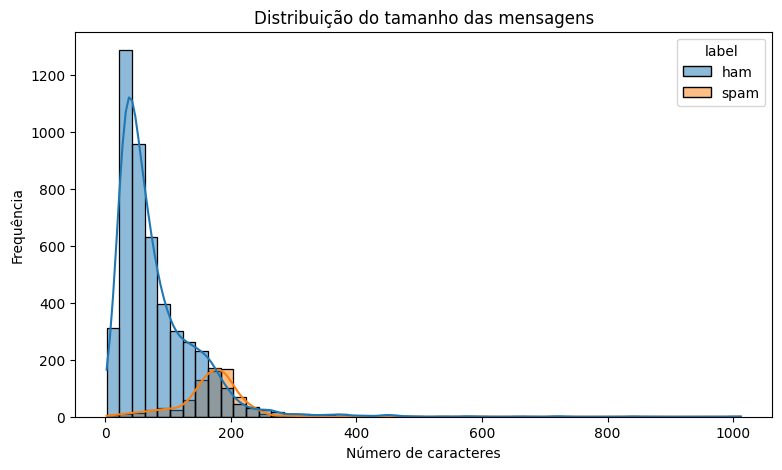

In [7]:
# Histograma do comprimento das mensagens
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))
sns.histplot(data=spam, x='char_count', hue='label', bins=50, kde=True)
plt.title('Distribuição do tamanho das mensagens')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.savefig('figures/histograma.png')
plt.show()

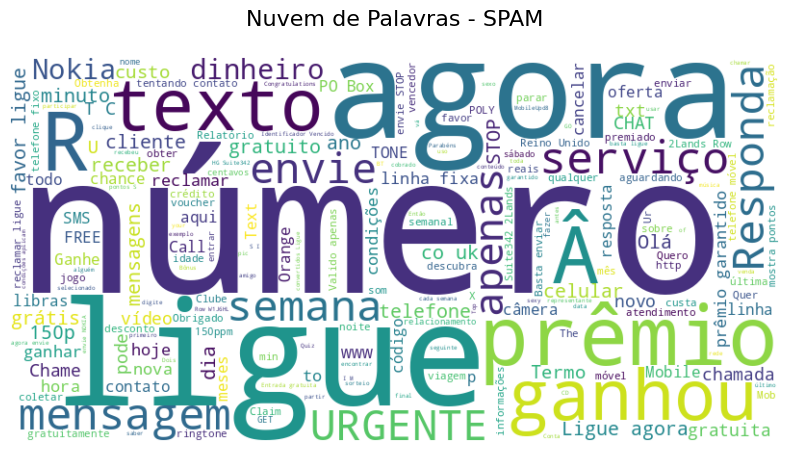

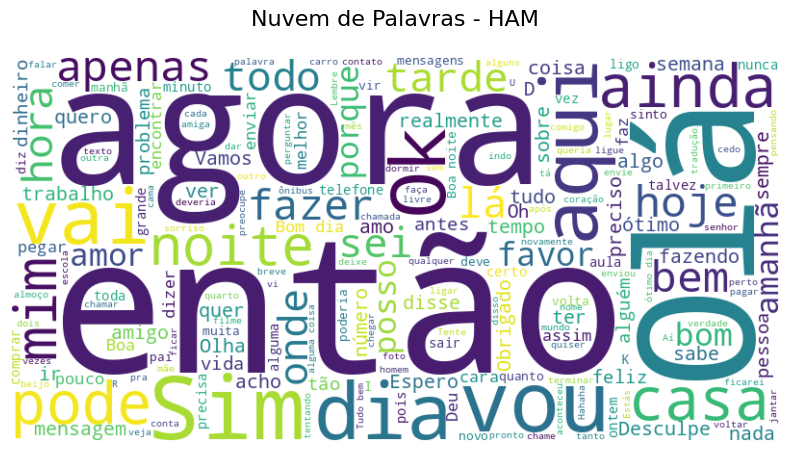

In [8]:
# Nuvem de palavras
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud  

nltk.download('stopwords', quiet=True)

def generate_wordcloud(text, title, save_path=None):
    # Obtém stopwords em português
    stopwords_pt = set(stopwords.words('portuguese'))
    
    # Gera a nuvem de palavras
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_pt).generate(text)
    
    # Cria a figura
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    
    # Salva
    if save_path:
        plt.savefig(save_path)

    # Exibe
    plt.show()


spam_text = ' '.join(spam[spam['label'] == 'spam']['sms'])
ham_text = ' '.join(spam[spam['label'] == 'ham']['sms'])

generate_wordcloud(spam_text, 'Nuvem de Palavras - SPAM\n', save_path='figures/nuvem_palavras_spam.png')
generate_wordcloud(ham_text, 'Nuvem de Palavras - HAM\n', save_path='figures/nuvem_palavras_ham.png')

Total de palavras distintas em SPAM (após limpeza): 2422
Total de palavras distintas em HAM (após limpeza): 7165


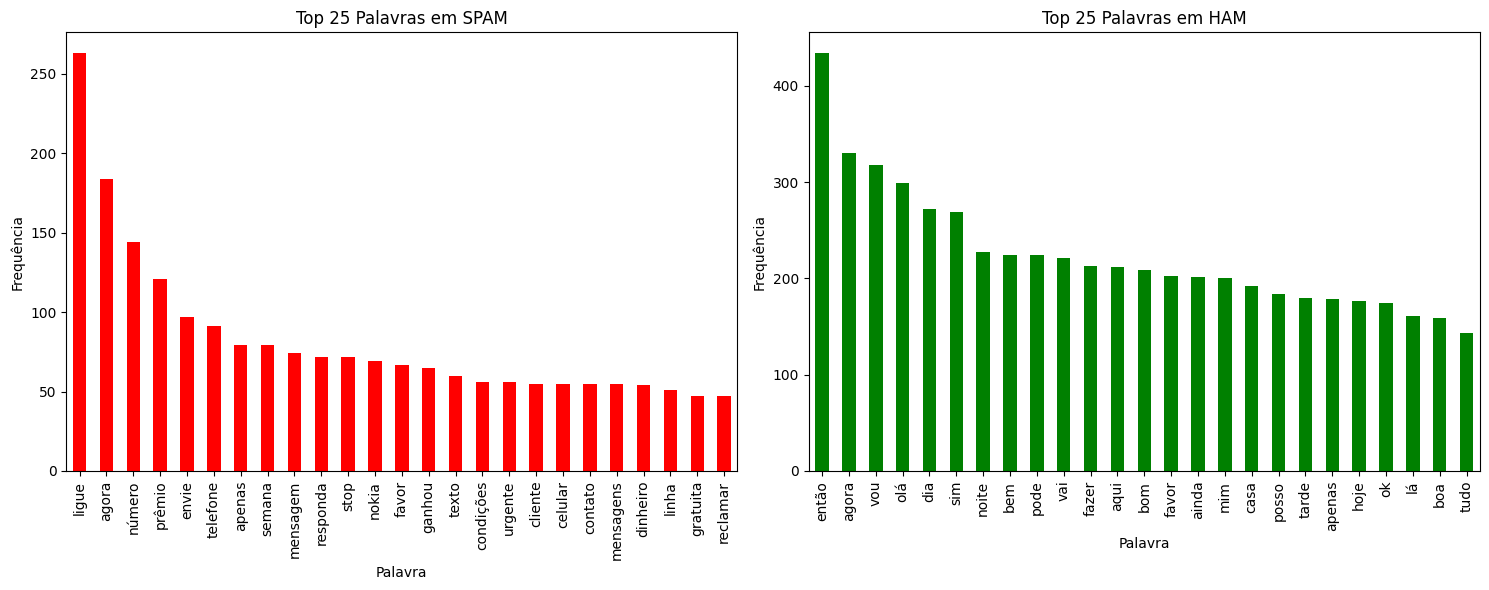

In [11]:
# Frequência de palavras
from collections import Counter

# Baixar recursos do NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Função de limpeza e tokenização
def get_word_frequencies(text_series):
    stop_words = set(stopwords.words('portuguese'))
    all_words = []
    for message in text_series:
        # Tokenizar em palavras, normalizar e filtrar
        words = nltk.word_tokenize(message.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 1]
        all_words.extend(words)
    return Counter(all_words), set(all_words)  # Retorna também o conjunto de palavras únicas

# Frequências e vocabulário para SPAM
spam_freq, spam_vocab = get_word_frequencies(spam[spam['label'] == 'spam']['sms'])

# Frequências e vocabulário para HAM
ham_freq, ham_vocab = get_word_frequencies(spam[spam['label'] == 'ham']['sms'])

# Total de palavras distintas (sem stopwords e pontuação)
print(f"Total de palavras distintas em SPAM (após limpeza): {len(spam_vocab)}")
print(f"Total de palavras distintas em HAM (após limpeza): {len(ham_vocab)}")

# Transformar as frequências em DataFrame para visualização
common_words = 25
spam_df = pd.DataFrame(spam_freq.most_common(common_words), columns=["Palavra", "Frequência"])
ham_df = pd.DataFrame(ham_freq.most_common(common_words), columns=["Palavra", "Frequência"])

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para SPAM
spam_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax1, color='red', legend=False)
ax1.set_title(f'Top {common_words} Palavras em SPAM')
ax1.set_xlabel('Palavra')
ax1.set_ylabel('Frequência')

# Gráfico de barras para HAM
ham_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax2, color='green', legend=False)
ax2.set_title(f'Top {common_words} Palavras em HAM')
ax2.set_xlabel('Palavra')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.savefig('figures/top_25_palavras.png')
plt.show()

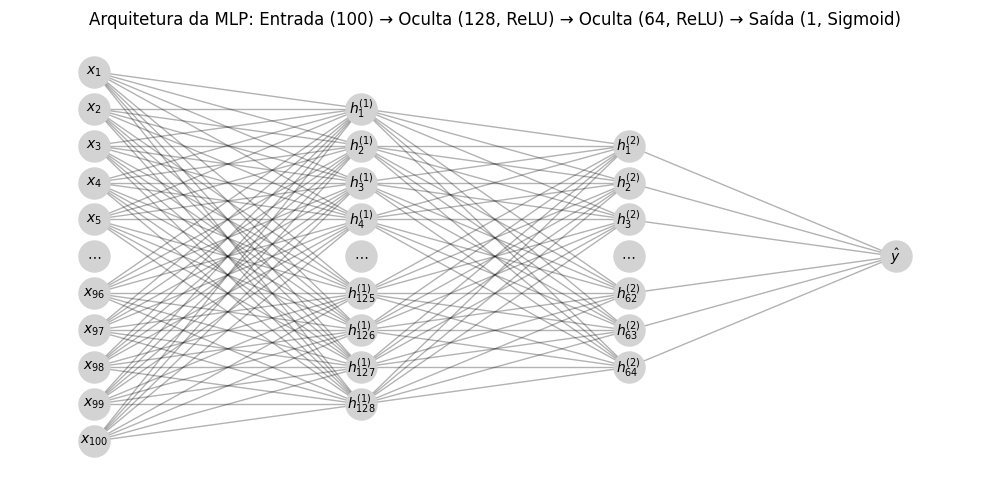

In [12]:
# Arquitetura planejada
import networkx as nx

# Versão reduzida e ilustrativa da arquitetura real
def insert_ellipsis(layer, prefix, total_nodes):
    half = len(layer) // 2
    return (
        [f'{prefix}_{{{i+1}}}' for i in range(half)]
        + ['ellipsis']
        + [f'{prefix}_{{{total_nodes - half + i}}}' for i in range(half)]
    )

# Camadas com reticências inseridas
input_layer = insert_ellipsis([None]*10, 'x', 101)             # Entrada: 100 tokens (exibindo 10)
hidden_layer1 = insert_ellipsis([None]*8, 'h^{{(1)}}', 129)    # Oculta 1: 128 neurônios
hidden_layer2 = insert_ellipsis([None]*6, 'h^{{(2)}}', 65)     # Oculta 2: 64 neurônios
output_layer = [r'\hat{y}']                                    # Saída: 1 nó

layers = [input_layer, hidden_layer1, hidden_layer2, output_layer]

# Criar grafo
G = nx.DiGraph()
positions = {}
labels = {}

layer_dist = 2.5
node_dist = 1.0

for i, layer in enumerate(layers):
    offset = (max(len(l) for l in layers) - len(layer)) / 2
    for j, node in enumerate(layer):
        is_ellipsis = node == 'ellipsis'
        node_name = f'{i}_{j}' if is_ellipsis else node
        G.add_node(node_name)
        y_pos = -(j + offset) * node_dist
        positions[node_name] = (i * layer_dist, y_pos)
        labels[node_name] = r"$\cdots$" if is_ellipsis else f"${node}$"

# Conexão entre camadas (pulando reticências)
def connect_layers(layer1, layer2, i1, i2):
    for u_j, u in enumerate(layer1):
        if u == 'ellipsis': continue
        u_name = f'{i1}_{u_j}' if u == 'ellipsis' else u
        for v_j, v in enumerate(layer2):
            if v == 'ellipsis': continue
            v_name = f'{i2}_{v_j}' if v == 'ellipsis' else v
            G.add_edge(u_name, v_name)

connect_layers(input_layer, hidden_layer1, 0, 1)
connect_layers(hidden_layer1, hidden_layer2, 1, 2)
connect_layers(hidden_layer2, output_layer, 2, 3)

# Desenho
plt.figure(figsize=(10, 5))
nx.draw_networkx_nodes(G, positions, node_color='lightgray', node_size=500)
nx.draw_networkx_edges(G, positions, arrows=False, alpha=0.3, width=1)
nx.draw_networkx_labels(G, positions, labels, font_size=10)

plt.title('Arquitetura da MLP: Entrada (100) → Oculta (128, ReLU) → Oculta (64, ReLU) → Saída (1, Sigmoid)', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/arquitetura.png')
plt.show()

In [13]:
# Bibliotecas usadas para o treinamento
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
import os

In [14]:
# Codificação dos rótulos (ham = 0, spam = 1)
le = LabelEncoder()
spam['label_enc'] = le.fit_transform(spam['label'])
spam.tail()

,label,sms,word_count,char_count,label_enc
5567,spam,Esta é a 2ª vez que tentamos contato com você....,34,187,1
5568,ham,Vai para a praia de casa.,6,25,0
5569,ham,"Pity, estava em dia para isso. Então... quaisq...",10,67,0
5570,ham,"O cara fez algumas reclamações, mas eu fui com...",23,120,0
5571,ham,Hahahahahahahah! É verdadeiro em sua denominação.,6,49,0


In [15]:
# Divisão estratificada: 70% treino, 15% validação, 15% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    spam['sms'], spam['label_enc'], test_size=0.15, stratify=spam['label_enc'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)  # 0.1765 de 85% ≈ 15%

print('Dados de treinamento', X_train.shape)
print('Dados de validação', X_val.shape)
print('Dados de teste', X_test.shape)

Dados de treinamento (3900,)
Dados de validação (836,)
Dados de teste (836,)


In [16]:
# Tokenização
tokenizador_file = 'model/tokenizer.pkl'

if os.path.exists(tokenizador_file):
    # Abrir o arquivo e carregar
    print('Carregando tokenizador...')
    with open(tokenizador_file, 'rb') as f:
        tokenizer = pickle.load(f)
else:
    print('Criando tokenizador...')
    max_words = 10000
    maxlen = 200

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Salvar o tokenizador
    os.makedirs('model', exist_ok=True)  # Garantir que a pasta exista
    with open(tokenizador_file, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f'Tokenizador salvo em: {tokenizador_file}')

# Transformar textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Aplicar padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Determinar o número real de palavras (pode ser < max_words)
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

# print(f'Word index = {word_index}')
print(f'Palavras = {num_words}')

Criando tokenizador...
Tokenizador salvo em: model/tokenizer.pkl
Palavras = 8185


In [20]:
# Construção do modelo MLP com embedding treinável, seguindo a estrutura
# Entrada (100) → Pooling → Oculta (128, ReLU) → Dropout → Oculta (64, ReLU) → Dropout → Saída (1, Sigmoid)
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, trainable=True),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    # Dropout(0.5),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')  # Saída binária
])

# Configuração do otimizador
optimizer = Adam(learning_rate=0.001)

# Métricas para acompanhamento
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Sumário do modelo
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │       818,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,749 (3.20 MB)

 Trainable params: 839,749 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Cálculo dos pesos das classes (balanceamento do desbalanceamento)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print('Pesos {0 = HAM, 1 = SPAM} ] =', class_weights_dict)

Pesos {0 = HAM, 1 = SPAM} ] = {0: 0.5774355937222386, 1: 3.72848948374761}


In [23]:
# Treinamento com EarlyStopping ou carregamento do modelo salvo
model_file = 'model/spam.keras'

if os.path.exists(model_file):
    print('Modelo já existente encontrado. Carregando...')
    model = load_model(model_file)
else:
    print('Treinando novo modelo MLP...')
    es = EarlyStopping(patience=3, restore_best_weights=True)

    # Definindo as métricas
    metrics = ['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[es],
        class_weight=class_weights_dict,
    )

    # Criar pasta se não existir
    os.makedirs(os.path.dirname(model_file), exist_ok=True)

    # Salvar o modelo treinado
    model.save(model_file)
    print(f'Modelo salvo em: {model_file}')

Treinando novo modelo MLP...
Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.8212 - auc: 0.7207 - loss: 0.6640 - precision: 0.2180 - recall: 0.2207 - val_accuracy: 0.9629 - val_auc: 0.9701 - val_loss: 0.4925 - val_precision: 0.9655 - val_recall: 0.7500
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7684 - auc: 0.7914 - loss: 0.5678 - precision: 0.3366 - recall: 0.6454 - val_accuracy: 0.9653 - val_auc: 0.9734 - val_loss: 0.2268 - val_precision: 0.9192 - val_recall: 0.8125
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9087 - auc: 0.9471 - loss: 0.3160 - precision: 0.6314 - recall: 0.8847 - val_accuracy: 0.9653 - val_auc: 0.9767 - val_loss: 0.1066 - val_precision: 0.9368 - val_recall: 0.7946
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9605 - auc: 0.9748 - loss: 0.1647 - precision: 0.8130 - recall: 0.9139 - val_accuracy: 0.9701 - val_auc: 0.9790 - val_loss: 0.1007 - val_precision: 0.9223 - val_recall: 0.

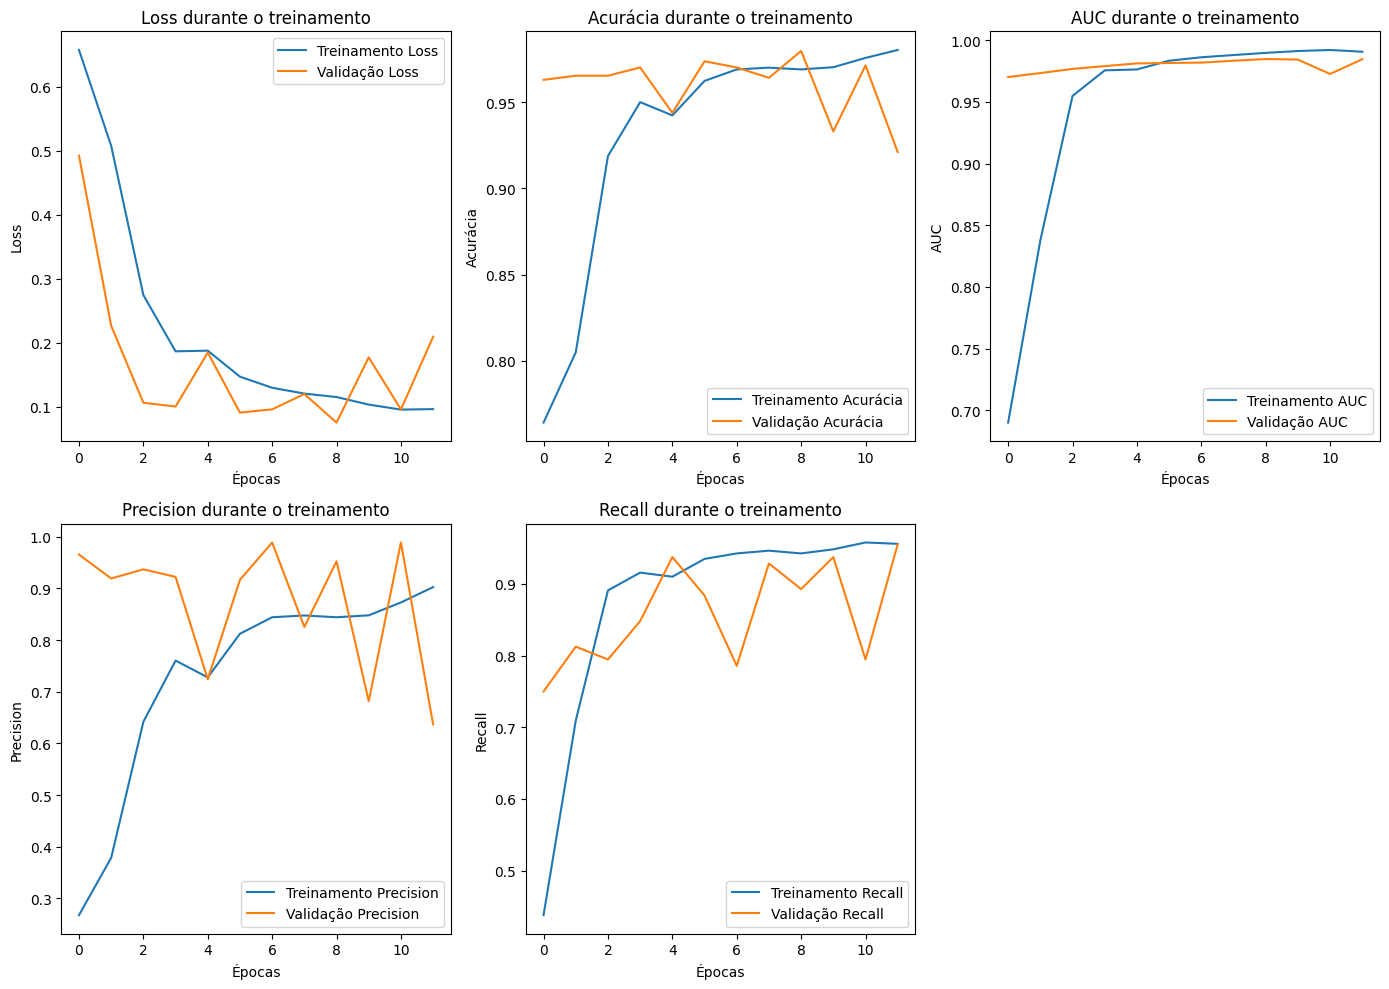

In [24]:
# Plotando gráficos do treinamento
plt.figure(figsize=(14, 10))

# Gráfico de Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Treinamento Loss')
plt.plot(history.history['val_loss'], label='Validação Loss')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Gráfico de Acurácia
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Treinamento Acurácia')
plt.plot(history.history['val_accuracy'], label='Validação Acurácia')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de AUC (Área sob a Curva)
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Treinamento AUC')
plt.plot(history.history['val_auc'], label='Validação AUC')
plt.title('AUC durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

# Gráfico de Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Treinamento Precision')
plt.plot(history.history['val_precision'], label='Validação Precision')
plt.title('Precision durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precision')
plt.legend()

# Gráfico de Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Treinamento Recall')
plt.plot(history.history['val_recall'], label='Validação Recall')
plt.title('Recall durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()


# Exibir gráficos
plt.tight_layout()
plt.savefig('figures/treinamento.png')
plt.show()

Avaliação no conjunto de teste...
Test Loss: 0.0730586051940918
Test Accuracy: 0.9772727489471436
Test AUC: 0.987038791179657
Test Precision: 0.9603960514068604
Test Recall: 0.8660714030265808
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


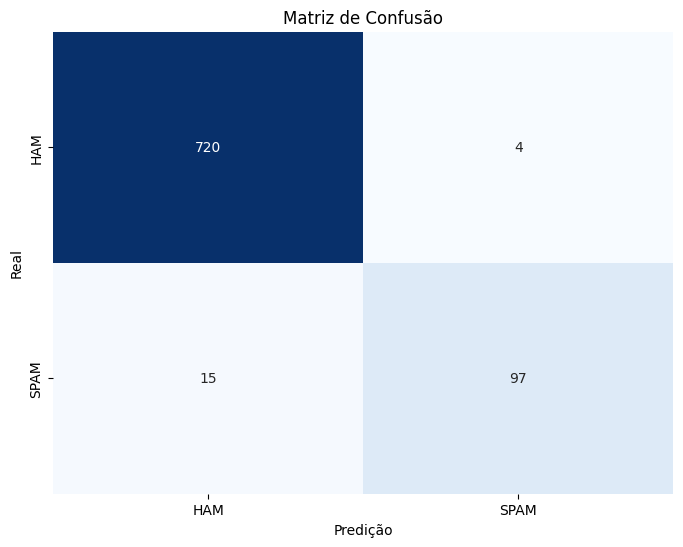

In [25]:
# Avaliar o modelo no conjunto de teste
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

print("Avaliação no conjunto de teste...")
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(
    X_test_pad, y_test, verbose=0
)

# Imprimir as métricas de teste
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Predições no conjunto de teste
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)  # Supondo que a saída seja binária

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando a Matriz de Confusão com um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.savefig('figures/matriz_confusao.png')
plt.show()



Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.96      0.87      0.91       112

    accuracy                           0.98       836
   macro avg       0.97      0.93      0.95       836
weighted avg       0.98      0.98      0.98       836



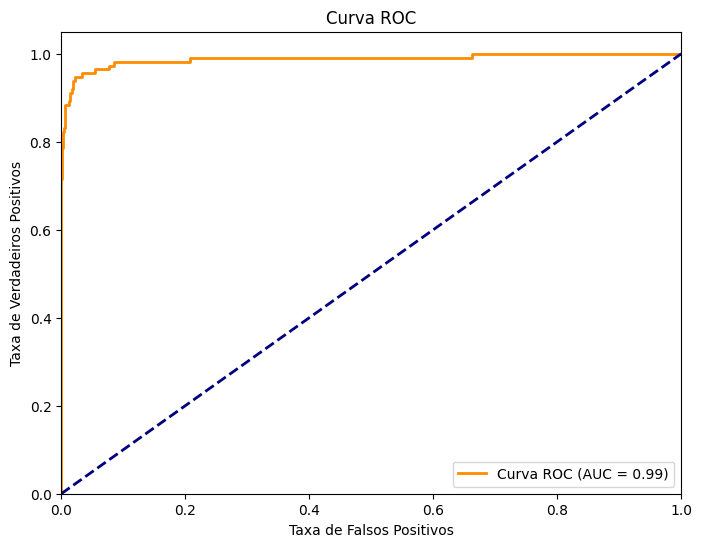

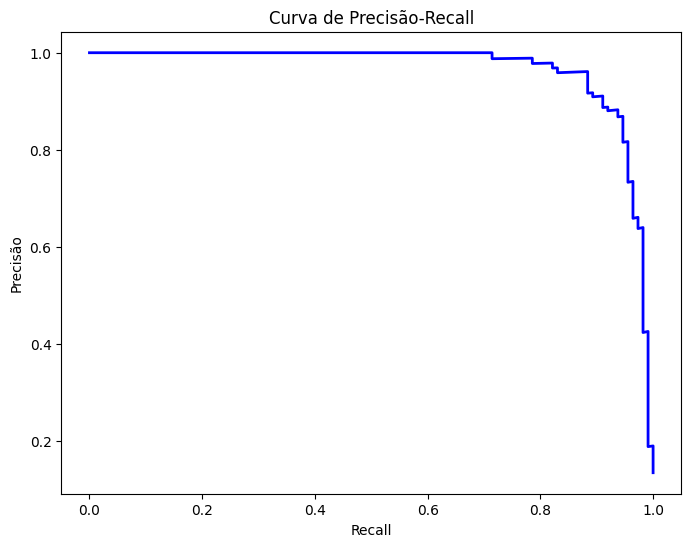

In [26]:
# Relatório de Classificação (precisão, recall, f1-score)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.savefig('data/curva_roc.png')
plt.show()

# Se você quiser também plotar a Curva de Precisão-Recall, aqui está o código:

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plotando a Curva de Precisão-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão-Recall')
plt.savefig('data/curva_precisao_recal.png')
plt.show()

In [27]:
# Carregamentos para teste do modelo
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Função de pré-processamento de texto
def preprocess_text(text, tokenizer, max_len=200):
    # Remove caracteres não alfanuméricos (opcional)
    text = re.sub(r'\W', ' ', text)
    text = text.lower()  # Convertendo para minúsculas
    
    # Convertendo o texto em sequência de inteiros
    seq = tokenizer.texts_to_sequences([text])
    
    # Padronizando o tamanho da sequência
    return pad_sequences(seq, maxlen=max_len)

# Arquivos do modelo
model_file = 'model/spam.keras'
tokenizer_file = 'model/tokenizer.pkl'

# Carregar o modelo treinado
model = load_model('model/spam.keras')

# Carregar o modelo salvo
if os.path.exists(model_file):
    # Abrir o arquivo e carregar
    print('Carregando modelo...')
    model = load_model(model_file)
else:
    print('Erro: Modelo não encontrado. Treine o modelo primeiro.')
    exit()

# Carregar o tokenizer salvo
if os.path.exists(tokenizer_file):
    # Abrir o arquivo e carregar
    print('Carregando tokenizador...')
    with open(tokenizer_file, 'rb') as f:
        tokenizer = pickle.load(f)
else:
    print('Erro: Tokenizador não encontrado. Treine o modelo primeiro.')
    exit()

Carregando modelo...
Carregando tokenizador...


In [29]:
# Mensagens para testar
messages = [
    'Parabéns! Você ganhou um prêmio! Ligue 1234-9990 agora para reivindicar.',
    'Não se esqueça da reunião às 10h amanhã.',
    'Você ganhou 500 reais! Ligue agora para 08007888 e resgate seu prêmio.',
    'Oferta por tempo limitado! Pegue seu presente grátis agora!',
    'Você ganhou 1000 reais. Clique nesse link para receber.',
    'Eu amo programar, é muito divertido!',
    'Sua conta foi comprometida, ligue para 555-1234 para redefinir sua senha imediatamente.'
]

# Loop para classificar cada mensagem
for message in messages:
    # Pré-processar a entrada da mensagem
    processed_input = preprocess_text(message, tokenizer)
    
    # Fazer a previsão (0 = HAM, 1 = SPAM)
    prediction_prob = model.predict(processed_input)[0][0]
    
    # Definir o rótulo com base na probabilidade
    if prediction_prob > 0.5:
        label = 'SPAM'
    else:
        label = 'HAM'
    
    # Exibir a classificação e a probabilidade
    print(f'{label}: {message}')
    print(f'Probabilidades: [SPAM = {prediction_prob:.4f}% | HAM = {1 - prediction_prob:.4f}%]')
    print('-' * 50)  # Separador entre mensagens

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SPAM: Parabéns! Você ganhou um prêmio! Ligue 1234-9990 agora para reivindicar.
Probabilidades: [SPAM = 0.7678% | HAM = 0.2322%]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
HAM: Não se esqueça da reunião às 10h amanhã.
Probabilidades: [SPAM = 0.0196% | HAM = 0.9804%]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
SPAM: Você ganhou 500 reais! Ligue agora para 08007888 e resgate seu prêmio.
Probabilidades: [SPAM = 0.9671% | HAM = 0.0329%]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
HAM: Oferta por tempo limitado! Pegue seu presente grátis agora!
Probabilidades: [SPAM = 0.3590% | HAM = 0.6410%]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
HAM: Você ganhou 1000 reais. Clique nesse link para receber.
Probabilidades: [SPAM = 0.3649% | HAM = 0.6351%]
---------------------------------